# Pandas Continuation

### Load basic libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('max_columns', 15)
pd.set_option('chained_assignment', None)

### Load data from a csv or zip file


In [2]:
# Data reference
filename = "./data/abcnews-headlines.zip"

In [3]:
# Load the model into a dataframe 'df'
df = pd.read_csv(filename)

### Basic data inspection

In [4]:
# Get total size of the Dataset
df.shape

(1186018, 2)

In [5]:
# Get some statistics: types, first rows, last rows, etc
print(f"Dataframe types:\n{df.dtypes}\n")
df.head(3)

Dataframe types:
publish_date      int64
headline_text    object
dtype: object



,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit


In [6]:
df.tail(3)

,publish_date,headline_text
1186015,20191231,we have fears for their safety: victorian premier
1186016,20191231,when do the 20s start
1186017,20191231,yarraville shooting woman dead man critically ...


Note that publish_date should be datetime and not an integer.

Lets solve that and create some extra features.

In [7]:
df = pd.read_csv(filename, date_parser=pd.to_datetime, parse_dates=['publish_date'])
df.head(3)

,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit


In [8]:
# Create count of words and letters (without spaces)
df['words'] = df.headline_text.apply(lambda x: x.count(' ') + 1)
df['letters'] = df.headline_text.apply(len) - df['words'] + 1

In [9]:
# Show the head of the dataframe with the new fields
df.head(3)

,publish_date,headline_text,words,letters
0,2003-02-19,aba decides against community broadcasting lic...,6,45
1,2003-02-19,act fire witnesses must be aware of defamation,8,39
2,2003-02-19,a g calls for infrastructure protection summit,7,40


In [10]:
# Get statistics of the dataframe
df.describe()

,words,letters
count,1.186018e+06,1.186018e+06
mean,6.491294e+00,3.528434e+01
std,1.847492e+00,9.456404e+00
min,1.000000e+00,3.000000e+00
25%,5.000000e+00,2.900000e+01
50%,6.000000e+00,3.600000e+01
75%,8.000000e+00,4.100000e+01
max,1.500000e+01,6.700000e+01


In [11]:
# Add year, month and day into the dataframe and show the head of the modified dataframe
df['year'] = df.publish_date.apply(lambda x: x.year)
df['month'] = df.publish_date.apply(lambda x: x.month)
df['day'] = df.publish_date.apply(lambda x: x.day)

In [12]:
df.head(3)

,publish_date,headline_text,words,letters,year,month,day
0,2003-02-19,aba decides against community broadcasting lic...,6,45,2003,2,19
1,2003-02-19,act fire witnesses must be aware of defamation,8,39,2003,2,19
2,2003-02-19,a g calls for infrastructure protection summit,7,40,2003,2,19


#### Plot the words and letters across time

In [13]:
# Use publish_date as the index of a new dataset called 'dfn'
dfn = df.set_index('publish_date')

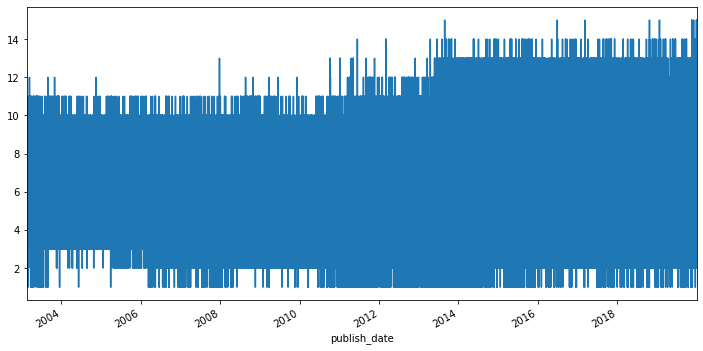

In [14]:
# Create a plot of the words over time
dfn.words.plot(figsize=(12, 6));

As this plot is not very indicative with all the noise, let's clear the noise to have in view the rolling average over a period of time.

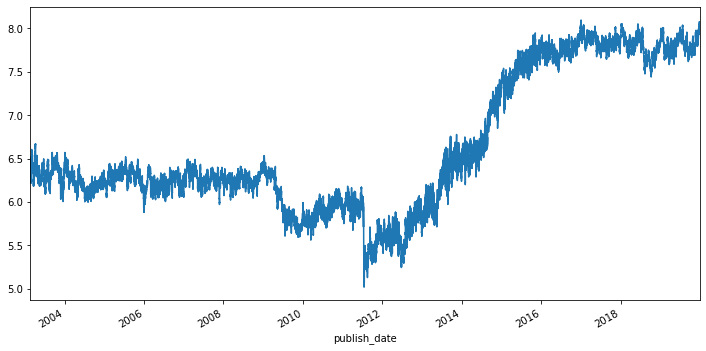

In [15]:
# Plot the rolling average using 1000 as the window for the average:
dfn.words.rolling(window=1000).mean().plot(figsize=(12, 6));

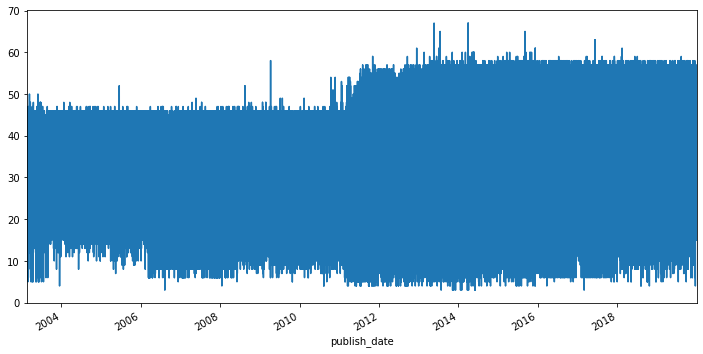

In [16]:
# Plot the letters length:
dfn.letters.plot(figsize=(12, 6)); 

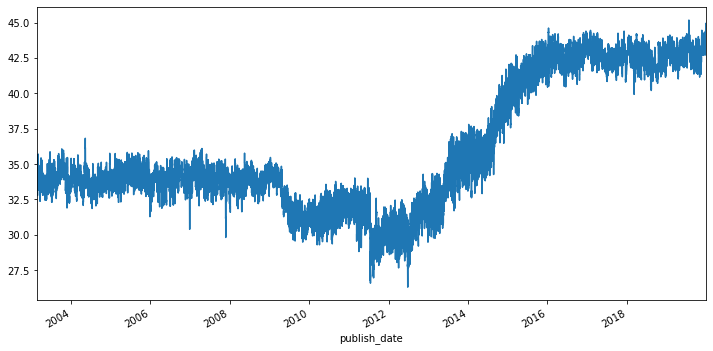

In [17]:
# As before the previous graphs is not very clear. Use now a rolling window of 365
dfn.letters.rolling(window=365).mean().plot(figsize=(12, 6));

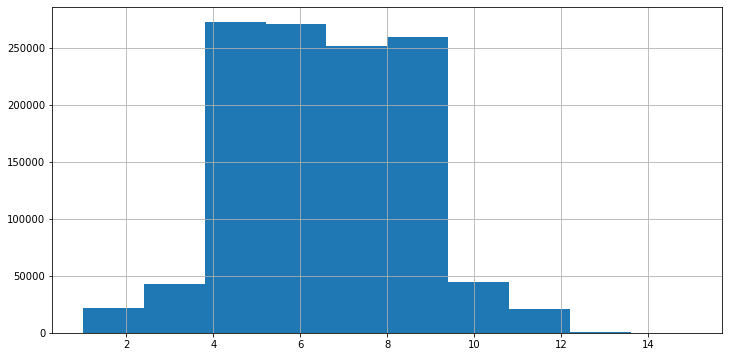

In [18]:
# Create the histogram of the words distribution
dfn.words.hist(figsize=(12, 6));

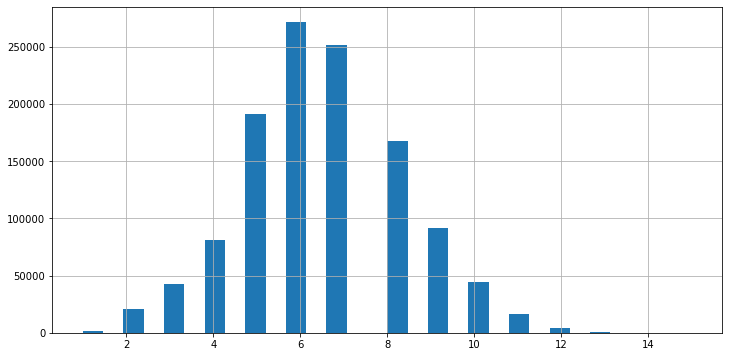

In [19]:
# Create the histogram of the words distribution using 30 bins
dfn.words.hist(figsize=(12, 6), bins=30);

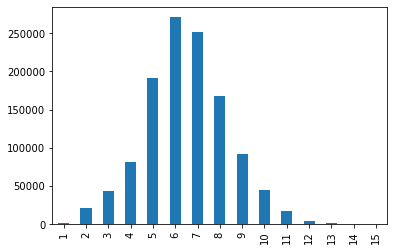

In [20]:
# Repeat the operation but using a plot with: kind='bar'
dfn.words.value_counts().sort_index().plot(kind='bar');

### Faster: x10 x100 x1000

#### Read data

In [21]:
# Load data from "abcnews-headlines.zip" and parse the "publish_date"
parser = lambda x: pd.datetime.strptime(x, "%Y%m%d")
df = pd.read_csv(filename, parse_dates=['publish_date'], date_parser=parser)

#### Data inspection

In [22]:
# Inspect the data
df.head(3)

,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit


#### Vectorizing a function

This is an example function to searcha for some specific string

In [23]:
def search(row, term="police", column="headline_text"):
    if term in row[column]:
        return row[column]
    else:
        return ""

In [27]:
# Create a subset of df with just a quarter of the data
df_subset = df.iloc[:df.shape[0]//4, :]

In [28]:
%%timeit
df_subset.apply(search, axis=1)

3.4 s ± 46.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
# Store the output
test = df_subset.apply(search, axis=1)

In [37]:
test[-10:]

296494                                           
296495                                           
296496                                           
296497    tas police charge 41 with drink driving
296498                                           
296499                                           
296500                                           
296501                                           
296502                                           
296503                                           
dtype: object

#### Apply   numpy.where

In [40]:
term = "police"
column="headline_text"

In [30]:
%%timeit
# Now repeat for the full dataset using directly numpy
# Pandas Series Vectorized oh yea!!
np.where(
    term in df[column],      # condition
    df[column],              # return if true
    ""                       # return if false
)

4.96 ms ± 99.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [65]:
idx = df[column].str.contains(term).values

result = np.where(
    idx,                     # condition: boolean list
    df[column],              # return if true
    ""                       # return if false
)

In [67]:
result[-10:]

array(['', '', '', '', '', '',
       'wa police and government backflip on drug amnesty bins', '', '',
       ''], dtype=object)

In [31]:
print(f"np.where is {round((14.5 * 1000) / 36.9, 1)}x faster than .apply")

np.where is 393.0x faster than .apply


#### numpy to the rescue

Let's access numpy directly to check if we get even faster...

In [35]:
 %%timeit
data = df["headline_text"].values
output2 = np.where(
    "police" in data,
    data, 
    ""
)

37.5 ms ± 504 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Matplotlib

Matplotlib is a plotting library.

The most important function in matplotlib is plot, which allows you to plot 2D data.

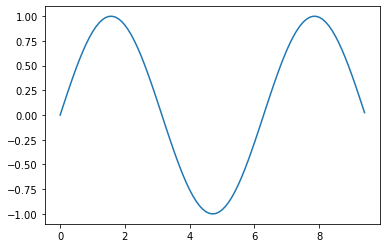

In [19]:
import matplotlib.pyplot as plt

# Compute the x and y coordinates for points on a sine curve
x = np.arange(0, 3 * np.pi, 0.1)
y = np.sin(x)

# Plot the points using matplotlib
plt.plot(x, y)

We can easily plot multiple lines at once and add a title, legend and axis labels:

Text(0.5, 0, 'x axis label')

Text(0, 0.5, 'y axis label')

Text(0.5, 1.0, 'Sine and Cosine')

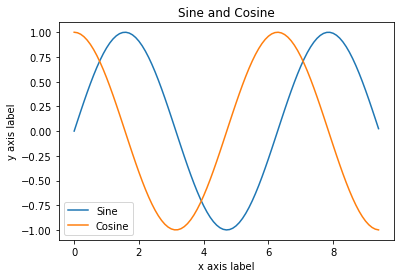

In [20]:
# Compute the x and y coordinates for points on sine and cosine curves
x = np.arange(0, 3 * np.pi, 0.1)
y_sin = np.sin(x)
y_cos = np.cos(x)

# Plot the points using matplotlib
plt.plot(x, y_sin)
plt.plot(x, y_cos)
plt.xlabel('x axis label')
plt.ylabel('y axis label')
plt.title('Sine and Cosine')
plt.legend(['Sine', 'Cosine'])

### Subplots

Text(0.5, 1.0, 'Sine')

Text(0.5, 1.0, 'Cosine')

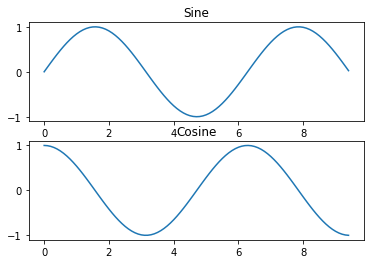

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the x and y coordinates for points on sine and cosine curves
x = np.arange(0, 3 * np.pi, 0.1)
y_sin = np.sin(x)
y_cos = np.cos(x)

# Set up a subplot grid that has height 2 and width 1,
# and set the first such subplot as active.
plt.subplot(2, 1, 1)

# Make the first plot
plt.plot(x, y_sin)
plt.title('Sine')

# Set the second subplot as active, and make the second plot.
plt.subplot(2, 1, 2)
plt.plot(x, y_cos)
plt.title('Cosine')

# Show the figure.
plt.show()

You can use the imshow function to show images.

Note that some image manipulation functions require the package Pillow to work.

In [23]:
#!pip install Pillow
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt

img = imread('fig/titanic_01.jpg')
img_tinted = img * [1, 0.95, 0.9]

# Show the original image
plt.subplot(1, 2, 1)
plt.imshow(img)

# Show the tinted image
plt.subplot(1, 2, 2)

# A slight gotcha with imshow is that it might give strange results
# if presented with data that is not uint8. To work around this, we
# explicitly cast the image to uint8 before displaying it.
plt.imshow(np.uint8(img_tinted))

ImportError: cannot import name 'imread' from 'scipy.misc' (/Users/josesanz/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/scipy/misc/__init__.py)